In [17]:
import os
import platform
import subprocess
import pandas as pd
import numpy
from IPython.display import Image

RUNS = 10

FILENAME = 'CMP.csv'
FILENAMEFPGA = 'CMPFPGA.csv'

def system_info():
    print(os.name, platform.system(), platform.release())
    print(os.popen("clinfo | grep -B 2 -A 4 'Device Vendor ID'").read())
    print(os.popen("clinfo | grep NOTE -A 3").read())
    
# Creating Pandas DataFrame 
if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"version": [], "platform": [], "execution_time_ms": []})
    
# List previous data
# List previous data (average)
df.groupby(['platform', 'version']) \
  .agg({'version':'count', 'execution_time_ms':['mean', 'std']}) \
  .rename(columns={'version':'count','version':'executions'})# Creating Pandas DataFrame

executions  \
                                                          count   
platform                                   version                
pac_a10 : Intel PAC Platform (pac_ee00000) Original          10   
                                           Otimizado         10   

                                                     execution_time_ms  \
                                                                  mean   
platform                                   version                       
pac_a10 : Intel PAC Platform (pac_ee00000) Original            54495.0   
                                           Otimizado           46053.4   

                                                                   
                                                              std  
platform                                   version                 
pac_a10 : Intel PAC Platform (pac_ee00000) Original   1600.718242  
                                           Otimizado   266.177551

# MacBook Pro (13-inch, 2017)

In [2]:
system_info()

('posix', 'Darwin', '19.4.0')
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel
  Device Vendor ID                                0xffffffff
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.1
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     CPU
--
--
  Device Name                                     Intel(R) Iris(TM) Plus Graphics 640
  Device Vendor                                   Intel Inc.
  Device Vendor ID                                0x1024500
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.2(Mar 15 2020 21:29:48)
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     GPU



# MacBook Pro (13-inch, 2017) + Docker

In [11]:
system_info()

posix Linux 4.19.76-linuxkit
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU



# GPU-server (Hermes) + Docker (oneAPI)

In [13]:
system_info()

posix Linux 4.15.0-65-generic
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU



## PC João ACER Aspire E 15

In [6]:
system_info()

posix Linux 5.4.0-52-generic
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.11.8.0.27
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.11.8.0.27
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU
--
  Device Name                 

# Intel DevCloud

In [2]:
system_info()

posix Linux 4.15.18
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.11.11.0.13_160000
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.11.11.0.13_160000
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU




## OpenCL version

In [17]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-ocl2 -d 2 -aph 600 -c0 1.98e-7 -c1 1.77e-6 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "OpenCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

## OpenMP version

In [2]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-omp2  -aph 600 -c0 1.98e-7 -c1 1.77e-6 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "OpenMP/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenMP"], 
                                 "platform"         : ["Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz"], 
                                 "execution_time_ms": [int(result[0])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

## SYCL version (using Docker)

In [3]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-sycl2 -d 2 -aph 600 -c0 1.98e-7 -c1 1.77e-6 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "SYCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["SYCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

## FPGA_SYCL version (using Docker)

In [2]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-sycl2.fpga_emu -aph 600 -c0 1.98e-7 -c1 1.77e-6 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "FPGA_SYCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["FPGA_SYCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

FileNotFoundError: [Errno 2] No such file or directory: 'FPGA_SYCL/build/': 'FPGA_SYCL/build/'

In [16]:
df

,execution_time_ms,platform,version
0,1412.0,Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz,OpenMP
1,1636.0,Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz,OpenMP
2,1418.0,Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz,OpenMP
3,1402.0,Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz,OpenMP
4,1374.0,Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz,OpenMP
...,...,...,...
95,622.0,Intel(R) Gen9 HD Graphics NEO,SYCL
96,632.0,Intel(R) Gen9 HD Graphics NEO,SYCL
97,646.0,Intel(R) Gen9 HD Graphics NEO,SYCL
98,679.0,Intel(R) Gen9 HD Graphics NEO,SYCL


Text(0, 0.5, 'Execution time (ms)')

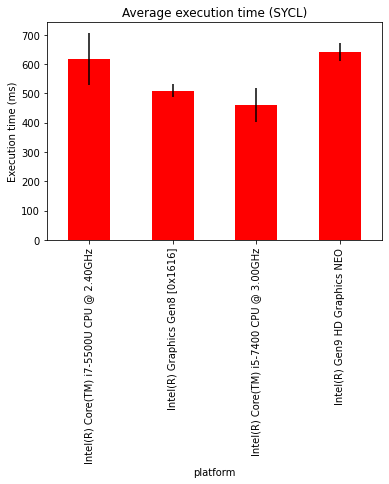

In [17]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df[df.version == 'SYCL'].groupby(by="platform", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std, color ="red")
plt.set_title("Average execution time (SYCL)")
plt.set_ylabel("Execution time (ms)")

Text(0, 0.5, 'Execution time (ms)')

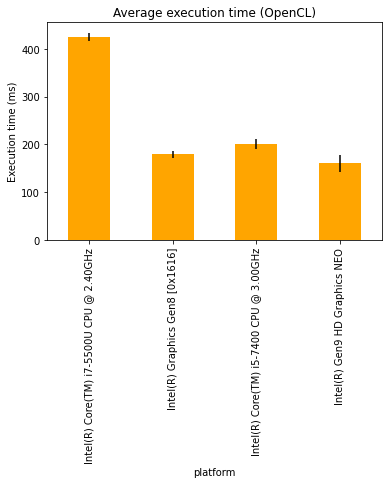

In [18]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df[df.version == 'OpenCL'].groupby(by="platform", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std, color="orange")
plt.set_title("Average execution time (OpenCL)")
plt.set_ylabel("Execution time (ms)")

Text(0, 0.5, 'Tempo de execução (ms)')

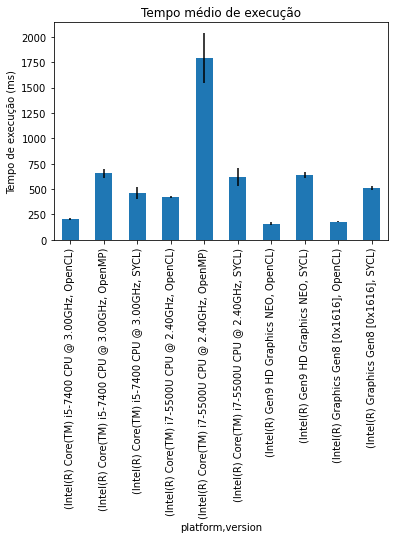

In [3]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df.groupby(['platform', 'version'])
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std)
plt.set_title("Tempo médio de execução")
plt.set_ylabel("Tempo de execução (ms)")

Text(0, 0.5, 'Tempo de execução (ms)')

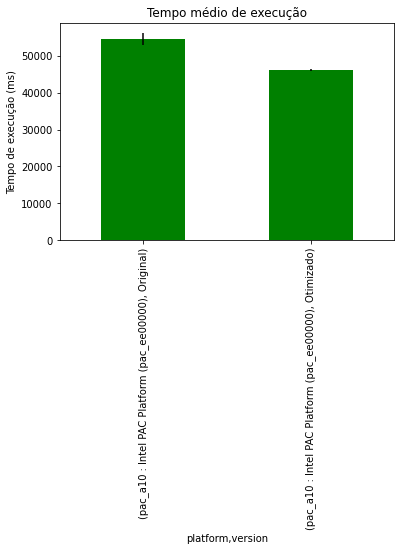

In [5]:
# Plot results
df = pd.read_csv(FILENAMEFPGA)
by_version = df.groupby(['platform', 'version'])
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std, color="green")
plt.set_title("Tempo médio de execução")
plt.set_ylabel("Tempo de execução (ms)")

In [18]:
if os.path.isfile(FILENAMEFPGA):
    dfn = pd.read_csv(FILENAMEFPGA)
else:
    dfn = pd.DataFrame({"version": [], "platform": [], "execution_time_ms": []})
    
# List previous data
# List previous data (average)
dfn.groupby(['platform', 'version']) \
  .agg({'version':'count', 'execution_time_ms':['mean', 'std']}) \
  .rename(columns={'version':'count','version':'executions'})

executions  \
                                                          count   
platform                                   version                
pac_a10 : Intel PAC Platform (pac_ee00000) Original          10   
                                           Otimizado         10   

                                                     execution_time_ms  \
                                                                  mean   
platform                                   version                       
pac_a10 : Intel PAC Platform (pac_ee00000) Original            54495.0   
                                           Otimizado           46053.4   

                                                                   
                                                              std  
platform                                   version                 
pac_a10 : Intel PAC Platform (pac_ee00000) Original   1600.718242  
                                           Otimizado   266.177551

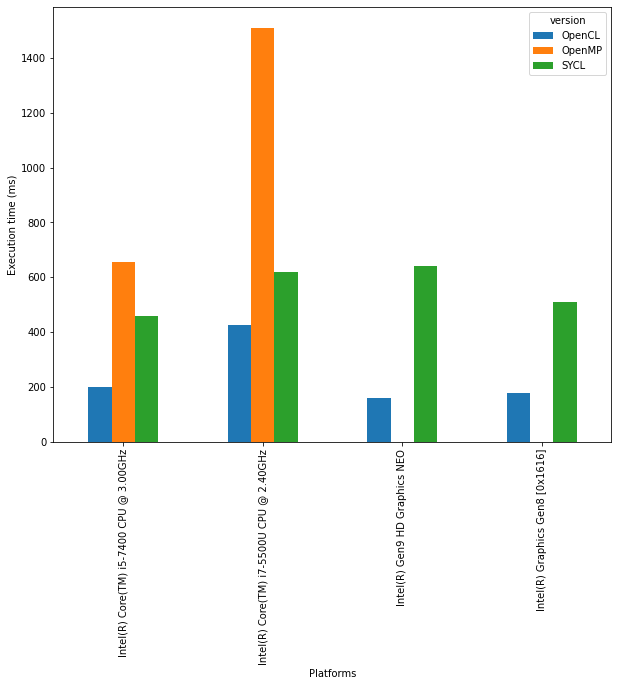

In [10]:
# Plot results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(FILENAME)
df["version"] = pd.Categorical(df["version"])
df_pivot = pd.pivot_table(
    df,
    values = "execution_time_ms",
    index = "platform",
    columns = "version",
    aggfunc = np.mean   
)

# Plot a bar chart using the DF
ax = df_pivot.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)
# Change the axes labels
ax.set_xlabel("Platforms")
ax.set_ylabel("Execution time (ms)")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
fig.savefig("page_views_barplot.png")

In [52]:
#===================================CREATE CMP DIRECTORY FOR IMAGES===================================
os.system("rm -r ../../datasets/CMP")
os.system("mkdir ../../datasets/CMP")

0

In [41]:
#---------------------------------------Generate OpenCL Images----------------------------------------
os.system("suoldtonew < OpenCL/build/cmp.c.su | supsimage > ../../datasets/CMP/ocl-cmp.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/ocl-cmp.c.png ../../datasets/CMP/ocl-cmp.c.eps")
os.system("suoldtonew < OpenCL/build/cmp.coher.su | supsimage > ../../datasets/CMP/ocl-cmp.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/ocl-cmp.coher.png ../../datasets/CMP/ocl-cmp.coher.eps")
os.system("suoldtonew < OpenCL/build/cmp.stack.su | supsimage > ../../datasets/CMP/ocl-cmp.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/ocl-cmp.stack.png ../../datasets/CMP/ocl-cmp.stack.eps")
#---------------------------------------Generate OpenMP Images----------------------------------------
os.system("suoldtonew < OpenMP/build/cmp.c.su | supsimage > ../../datasets/CMP/omp-cmp.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/omp-cmp.c.png ../../datasets/CMP/omp-cmp.c.eps")
os.system("suoldtonew < OpenMP/build/cmp.coher.su | supsimage > ../../datasets/CMP/omp-cmp.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/omp-cmp.coher.png ../../datasets/CMP/omp-cmp.coher.eps")
os.system("suoldtonew < OpenMP/build/cmp.stack.su | supsimage > ../../datasets/CMP/omp-cmp.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/omp-cmp.stack.png ../../datasets/CMP/omp-cmp.stack.eps")
#---------------------------------------Generate SYCL Images------------------------------------------
os.system("suoldtonew < SYCL/build/cmp.c.su | supsimage > ../../datasets/CMP/sycl-cmp.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/sycl-cmp.c.png ../../datasets/CMP/sycl-cmp.c.eps")
os.system("suoldtonew < SYCL/build/cmp.coher.su | supsimage > ../../datasets/CMP/sycl-cmp.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/sycl-cmp.coher.png ../../datasets/CMP/sycl-cmp.coher.eps")
os.system("suoldtonew < SYCL/build/cmp.stack.su | supsimage > ../../datasets/CMP/sycl-cmp.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/sycl-cmp.stack.png ../../datasets/CMP/sycl-cmp.stack.eps")
#---------------------------------------Generate FPGA_SYCL Images------------------------------------------
os.system("suoldtonew < FPGA_SYCL/build/cmp.c.su | supsimage > ../../datasets/CMP/fpga_sycl-cmp.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/fpga_sycl-cmp.c.png ../../datasets/CMP/fpga_sycl-cmp.c.eps")
os.system("suoldtonew < FPGA_SYCL/build/cmp.coher.su | supsimage > ../../datasets/CMP/fpga_sycl-cmp.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/fpga_sycl-cmp.coher.png ../../datasets/CMP/fpga_sycl-cmp.coher.eps")
os.system("suoldtonew < FPGA_SYCL/build/cmp.stack.su | supsimage > ../../datasets/CMP/fpga_sycl-cmp.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CMP/fpga_sycl-cmp.stack.png ../../datasets/CMP/fpga_sycl-cmp.stack.eps")

0

../../datasets/CMP/ocl-cmp.c.png
../../datasets/CMP/omp-cmp.c.png
../../datasets/CMP/sycl-cmp.c.png
../../datasets/CMP/fpga_sycl-cmp.c.png
../../datasets/CMP/ocl-cmp.coher.png
../../datasets/CMP/omp-cmp.coher.png
../../datasets/CMP/sycl-cmp.coher.png
../../datasets/CMP/fpga_sycl-cmp.coher.png
../../datasets/CMP/ocl-cmp.stack.png
../../datasets/CMP/omp-cmp.stack.png
../../datasets/CMP/sycl-cmp.stack.png
../../datasets/CMP/fpga_sycl-cmp.stack.png


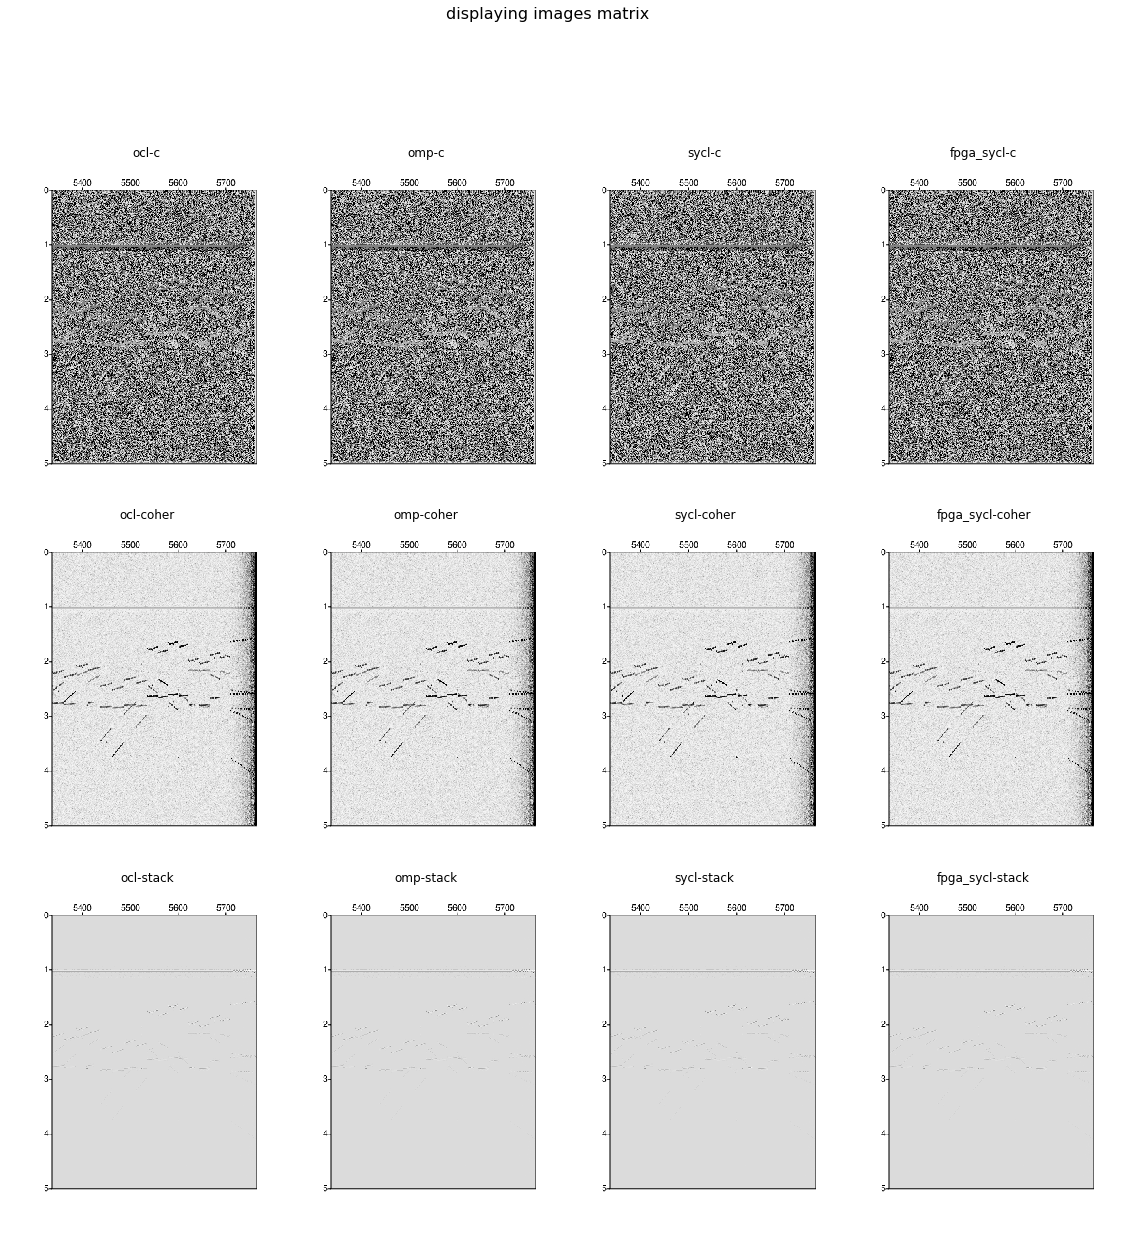

In [31]:
import matplotlib.pyplot as plt

names = ["c", "coher", "stack"]
versions = ["ocl", "omp", "sycl", "fpga_sycl"]

images = []
for i, name in enumerate(names):
    images.append([])
    for j, version in enumerate(versions):
        print("../../datasets/CMP/"+version+"-cmp."+name+".png")
        images[i].append(plt.imread("../../datasets/CMP/"+version+"-cmp."+name+".png"))
        
NUM_ROWS = len(names)
IMGs_IN_ROW = len(versions)

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(20, 20))

for i, row in enumerate(ax_arr):
    for j, ax in enumerate(row):
        ax.imshow(images[i][j])
        ax.set_frame_on(False)
        ax.axis('off')
        ax.set_title(versions[j]+"-"+names[i])
        ax.set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0)
        
title = 'displaying images matrix'
f.suptitle(title, fontsize=16)
plt.show()  